In [1]:
from collections import defaultdict
from trajdata import AgentType, UnifiedDataset
from trajdata.maps import MapAPI


env_name: str = "nusc_mini"

dataset = UnifiedDataset(
    desired_data=[env_name],
    data_dirs={  # Remember to change this to match your filesystem!
        env_name: "data/nuScenes/v1.0-mini_root",
    },
    cache_location="~/.unified_data_cache",
    only_types=[AgentType.VEHICLE],
    agent_interaction_distances=defaultdict(lambda: 50.0),
    incl_raster_map=True,
    raster_map_params={
        "px_per_m": 2,
        "map_size_px": 400,
        "offset_frac_xy": (-0.5, 0.0),
        "return_rgb": False,
    },
    desired_dt=0.1,
    num_workers=4,
    verbose=True,
)


Loading data for matched scene tags: ['nusc_mini-mini_train-boston', 'singapore-nusc_mini-mini_train', 'nusc_mini-mini_val-boston', 'singapore-nusc_mini-mini_val']


Calculating Agent Data (Serially): 100%|██████████| 10/10 [00:00<00:00, 25404.63it/s]

10 scenes in the scene index.



Structuring Agent Data Index: 100%|██████████| 10/10 [00:00<00:00, 8019.70it/s]


In [2]:
from trajdata import AgentBatch
from trajdata.maps import VectorMap
from trajdata.simulation import SimulationScene
from trajdata.data_structures.scene_metadata import Scene


SCENE_IDX = 0

desired_scene: Scene = list(dataset.scenes())[SCENE_IDX]
sim_scene: SimulationScene = SimulationScene(
    env_name=env_name,
    scene_name=f"sim_scene-{SCENE_IDX:04d}",
    scene=desired_scene,
    dataset=dataset,
    init_timestep=0,
    freeze_agents=True,
)


/home/linlongzhong/anaconda3/envs/tbsim/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(-8.6777)


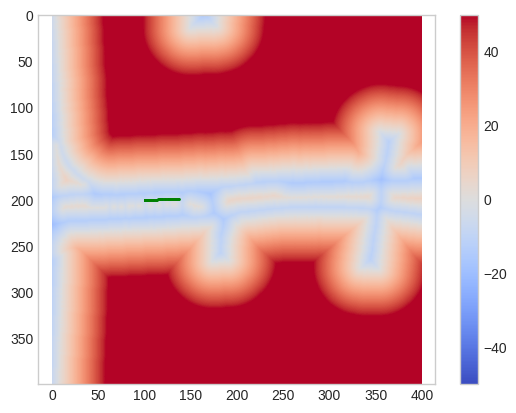

In [3]:
import torch
import numpy as np
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.ndimage import distance_transform_edt

def drivable_to_sdf(drivable: torch.Tensor) -> torch.Tensor:
    device = drivable.device
    mask = drivable.bool().cpu().numpy()
    dist_inside = distance_transform_edt(mask)
    dist_outside = distance_transform_edt(~mask)
    sdf = dist_outside - dist_inside
    return torch.from_numpy(sdf).float().to(device)


AGENT_IDX = 1

obs: AgentBatch = sim_scene.reset()

drivable = obs.maps[AGENT_IDX][0]
future_positions_local = obs.agent_fut.position[AGENT_IDX]
raster_from_world = obs.rasters_from_world_tf[AGENT_IDX] # 3*3 matrix
agent_from_world = obs.agents_from_world_tf[AGENT_IDX]
world_from_agent = torch.linalg.inv(agent_from_world)
raster_from_agent = raster_from_world @ world_from_agent

sdf = drivable_to_sdf(drivable)

## query
future_positions_local_homo = torch.cat([
    future_positions_local, torch.ones_like(future_positions_local[:, :1])
], dim=1)
future_positions_raster_homo = future_positions_local_homo @ raster_from_agent.T
future_positions_raster = future_positions_raster_homo[:, :2]

H, W = sdf.shape
future_positions_grid = torch.zeros_like(future_positions_raster)
future_positions_grid[:, 0] = future_positions_raster[:, 0] / W * 2 - 1
future_positions_grid[:, 1] = future_positions_raster[:, 1] / H * 2 - 1

signed_distance = F.grid_sample(
    sdf.unsqueeze(0).unsqueeze(0),
    future_positions_grid.unsqueeze(0).unsqueeze(0)
).squeeze()
print(signed_distance[0])

## visualize
plt.figure()
plt.axis('equal')
plt.grid(False)
plt.imshow(
    sdf, cmap='coolwarm',
    norm=TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50),
    zorder=0
)
plt.plot(
    future_positions_raster[:, 0], future_positions_raster[:, 1],
    'go', markersize=1,
    zorder=1,
)
plt.colorbar()
plt.show()
plt.close()